In [46]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split
import os.path
from collections import defaultdict
from os import path
import random

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

In [47]:
def getTLandBR(l, t, w, h):
    tl=(l,t) #x, y
    br=(l+w,t+h)
    return(tl, br)

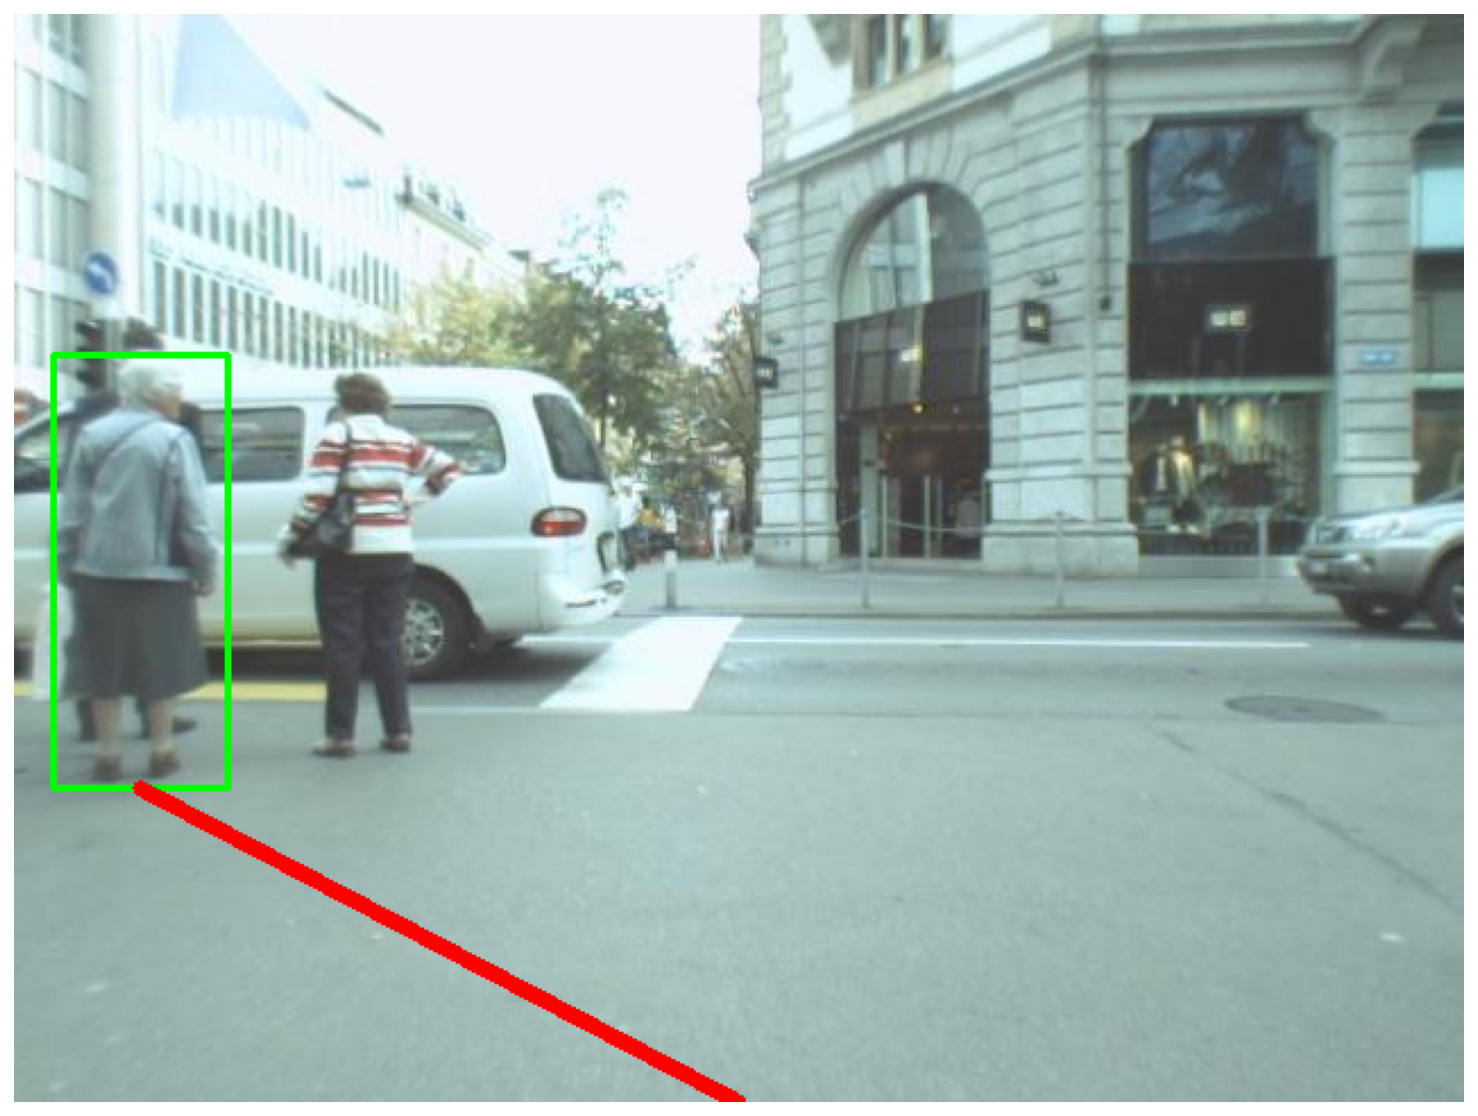

In [48]:
train_f = open('/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-05/gt/gt.txt',)
train_parent_dir = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-05/images/'

for line in train_f:
    frame, bb_id, bb_left, bb_top, bb_width, bb_height, x, y, z = line.split(",")
    filename = ((6 - len(frame)) * "0") + frame + ".jpg"
    
    image_for_frame = train_parent_dir + filename
    file_exists = path.exists(image_for_frame)
    if (file_exists):
        img = cv2.cvtColor(cv2.imread(image_for_frame), cv2.COLOR_BGR2RGB)
        
        ## draw bounding box
        bb_tl, bb_br = getTLandBR(int(bb_left), int(bb_top), int(bb_width), int(bb_height))
        cv2.rectangle(img, bb_tl, bb_br, color=(0, 255, 0), thickness = 2)
        
        ## trajectory to person
        x_midpoint = int(img.shape[1]/2)
        bb_b_mid = int(bb_br[0] - int(bb_width)/2)
        img = cv2.line(img,(bb_b_mid, bb_br[1]),(x_midpoint,img.shape[0]),(255,0,0),5)

    plt.imshow(img)
    plt.axis('off')
    break

17 150 77 191
20 136 69 190
240 199 25 66
566 181 228 98
-73 152 345 145
307 213 12 32
493 187 24 49
114 154 85 176
325 -9 325 257
259 204 19 47


(-0.5, 639.5, 479.5, -0.5)

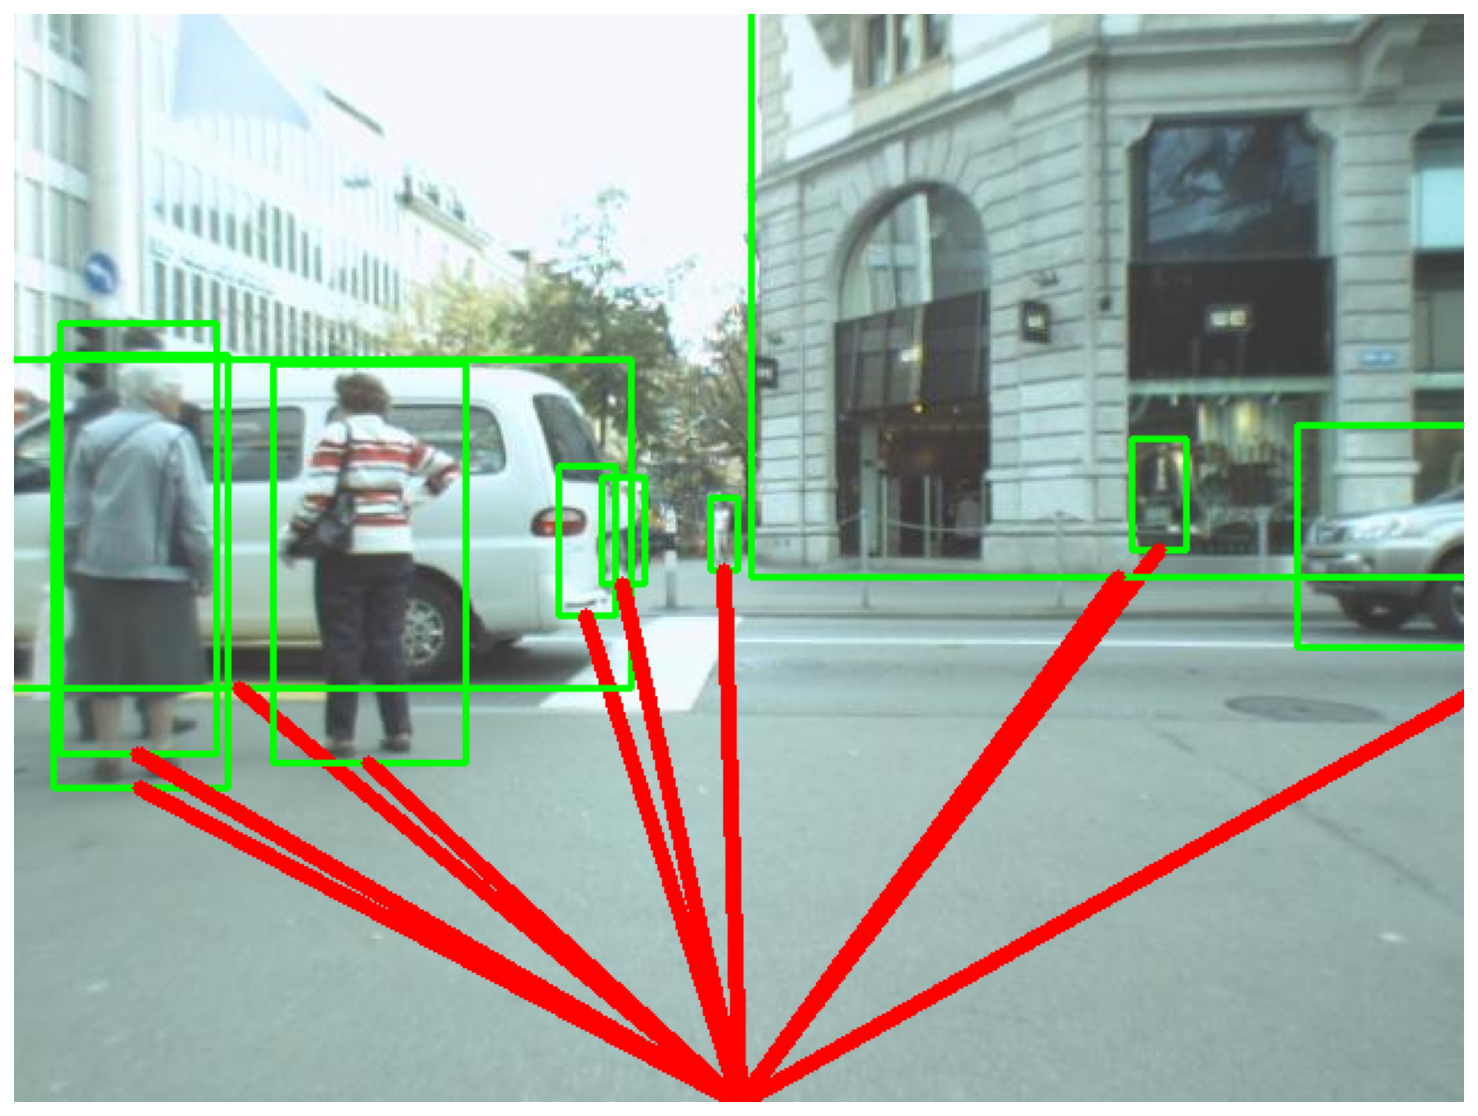

In [49]:
train_f = open('/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-05/gt/gt.txt',)
train_parent_dir = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-05/images/'
train_filename = "000001.jpg"

img = cv2.cvtColor(cv2.imread(train_parent_dir+train_filename), cv2.COLOR_BGR2RGB)

for line in train_f:
    frame, bb_id, bb_left, bb_top, bb_width, bb_height, x, y, z = line.split(",")
    filename = ((6 - len(frame)) * "0") + frame + ".jpg"
    
    if (filename == train_filename):
        ## draw bounding box
        print(int(bb_left), int(bb_top), int(bb_width), int(bb_height))
        bb_tl, bb_br = getTLandBR(int(bb_left), int(bb_top), int(bb_width), int(bb_height))
#         print(bb_tl, bb_br)
        cv2.rectangle(img, bb_tl, bb_br, color=(0, 255, 0), thickness = 2)

        ## trajectory to person
        x_midpoint = int(img.shape[1]/2)
        bb_b_mid = int(bb_br[0] - int(bb_width)/2)
        img = cv2.line(img,(bb_b_mid, bb_br[1]),(x_midpoint,img.shape[0]),(255,0,0),5)

plt.imshow(img)
plt.axis('off')

In [50]:
train_anno_MOT1702 = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-02/gt/gt.txt'
train_MOT1702_dir = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-02/img1/'
train_anno_MOT1704 = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-04/gt/gt.txt'
train_MOT1704_dir = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-04/img1/'
train_anno_MOT1705 = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-05/gt/gt.txt'
train_MOT1705_dir = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-05/images/'
train_anno_MOT1709 = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-09/gt/gt.txt'
train_MOT1709_dir = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-09/img1/'
train_anno_MOT1710 = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-10/gt/gt.txt'
train_MOT1710_dir = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-10/img1/'
train_anno_MOT1711 = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-11/gt/gt.txt'
train_MOT1711_dir = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-11/img1/'
train_anno_MOT1713 = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-13/gt/gt.txt'
train_MOT1713_dir = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-13/img1/'


gt_bbs_for_frame = defaultdict(list)

def parseData(annotation_file, image_dir, prefix):
#     print(annotation_file)
    file1 = open(annotation_file, 'r')
    train_anno_MOT17 = file1.readlines()
    
    for line in train_anno_MOT17:
#         print(line)
        frame, bb_id, bb_left, bb_top, bb_width, bb_height, x, y, z = line.split(",")
        filename = ((6 - len(frame)) * "0") + frame + ".jpg"

        image_for_frame = image_dir + filename
        file_exists = path.exists(image_for_frame)
        if (file_exists):
#             img = cv2.cvtColor(cv2.imread(image_for_frame), cv2.COLOR_BGR2RGB)

            bb_left, bb_top, bb_width, bb_height = max(int(bb_left), 0), max(int(bb_top), 0), max(int(bb_width), 0), max(int(bb_height), 0)
            gt_bbs_for_frame[prefix+filename].append((bb_left, bb_top, bb_width, bb_height))
    file1.close()
    print ("Done with ", annotation_file)

parseData(train_anno_MOT1702, train_MOT1702_dir, "MOT17-02/img1/")
parseData(train_anno_MOT1704, train_MOT1704_dir, "MOT17-04/img1/")
parseData(train_anno_MOT1705, train_MOT1705_dir, "MOT17-05/images/")
parseData(train_anno_MOT1709, train_MOT1709_dir, "MOT17-09/img1/")
parseData(train_anno_MOT1710, train_MOT1710_dir, "MOT17-10/img1/")
parseData(train_anno_MOT1711, train_MOT1711_dir, "MOT17-11/img1/")
parseData(train_anno_MOT1713, train_MOT1713_dir, "MOT17-13/img1/")
gt_bbs_for_frame

Done with  /Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-02/gt/gt.txt
Done with  /Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-04/gt/gt.txt
Done with  /Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-05/gt/gt.txt
Done with  /Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-09/gt/gt.txt
Done with  /Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-10/gt/gt.txt
Done with  /Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-11/gt/gt.txt
Done with  /Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-13/gt/gt.txt


defaultdict(list,
            {'MOT17-02/img1/000001.jpg': [(912, 484, 97, 109),
              (1338, 418, 167, 379),
              (586, 447, 85, 263),
              (1585, 0, 336, 578),
              (1163, 441, 33, 89),
              (1308, 431, 34, 118),
              (1416, 431, 184, 336),
              (1056, 484, 36, 110),
              (1091, 484, 31, 115),
              (734, 487, 29, 68),
              (679, 492, 53, 105),
              (738, 458, 27, 75),
              (1255, 447, 33, 100),
              (1016, 430, 40, 116),
              (1101, 441, 38, 108),
              (935, 436, 42, 114),
              (442, 446, 105, 283),
              (636, 458, 61, 187),
              (1364, 434, 51, 124),
              (1478, 434, 63, 124),
              (473, 460, 89, 249),
              (835, 473, 52, 75),
              (796, 476, 55, 60),
              (548, 465, 35, 93),
              (376, 446, 41, 104),
              (418, 459, 40, 84),
              (582, 456, 35, 133),
  

In [51]:
len(gt_bbs_for_frame)

5316

In [52]:
### write data to this dir
labels_dir = "/Users/arkwl/Desktop/Workstation/cs230-robot-project/labels/"

f_train = open(labels_dir + "train.txt", "w")
f_val = open(labels_dir + "val.txt", "w")
f_test = open(labels_dir + "test.txt", "w")
idx_for_image = 0
print(len(gt_bbs_for_frame))

last_train_example = 0
last_val_example = 0

l = list(gt_bbs_for_frame.items())
random.shuffle(l)
gt_bbs_for_frame = dict(l)

for (filename, bbs) in gt_bbs_for_frame.items():
    bb_text = ""
    for bb in bbs:
        l, t, w, h = bb
        tl, br = getTLandBR(l, t, w, h)
        bb_text += (str(tl[0])+","+str(tl[1])+","+str(br[0])+","+str(br[1])+",0 ")
    # img_width img_height box_1 box_2 ... box_n
        # label_index x_min y_min x_max y_max     in this case, label_index is always = 0, bc classnum == 1
    
    if (idx_for_image > len(gt_bbs_for_frame)-100):
        output_filename="test.txt"
        f_test.write("/content/drive/MyDrive/ColabNotebooks/cs230robot-tensorflow-REALONE/images/"+filename+ " " + bb_text + "\n")
    elif (idx_for_image > len(gt_bbs_for_frame)-200):
        last_val_example = idx_for_image
        output_filename="val.txt"
        f_val.write("/content/drive/MyDrive/ColabNotebooks/cs230robot-tensorflow-REALONE/images/"+filename+ " " + bb_text + "\n")
    else:
        last_train_example = idx_for_image
        print(filename)
        f_train.write("/content/drive/MyDrive/ColabNotebooks/cs230robot-tensorflow-REALONE/images/"+filename+ " " + bb_text + "\n")
    
    idx_for_image = idx_for_image + 1 
f_test.close()
f_val.close()
f_train.close()

5316
MOT17-09/img1/000091.jpg
MOT17-13/img1/000421.jpg
MOT17-13/img1/000743.jpg
MOT17-05/images/000800.jpg
MOT17-09/img1/000044.jpg
MOT17-04/img1/000701.jpg
MOT17-05/images/000554.jpg
MOT17-11/img1/000145.jpg
MOT17-04/img1/000606.jpg
MOT17-11/img1/000774.jpg
MOT17-11/img1/000509.jpg
MOT17-04/img1/000461.jpg
MOT17-05/images/000584.jpg
MOT17-05/images/000827.jpg
MOT17-13/img1/000042.jpg
MOT17-04/img1/000093.jpg
MOT17-11/img1/000080.jpg
MOT17-02/img1/000592.jpg
MOT17-04/img1/000664.jpg
MOT17-05/images/000541.jpg
MOT17-05/images/000070.jpg
MOT17-05/images/000367.jpg
MOT17-09/img1/000367.jpg
MOT17-10/img1/000453.jpg
MOT17-10/img1/000445.jpg
MOT17-04/img1/000251.jpg
MOT17-04/img1/000092.jpg
MOT17-13/img1/000216.jpg
MOT17-10/img1/000186.jpg
MOT17-10/img1/000342.jpg
MOT17-05/images/000797.jpg
MOT17-02/img1/000264.jpg
MOT17-10/img1/000464.jpg
MOT17-09/img1/000511.jpg
MOT17-13/img1/000062.jpg
MOT17-09/img1/000493.jpg
MOT17-10/img1/000340.jpg
MOT17-10/img1/000303.jpg
MOT17-04/img1/000296.jpg
MOT1

MOT17-11/img1/000242.jpg
MOT17-10/img1/000028.jpg
MOT17-05/images/000131.jpg
MOT17-13/img1/000561.jpg
MOT17-05/images/000326.jpg
MOT17-10/img1/000187.jpg
MOT17-11/img1/000450.jpg
MOT17-09/img1/000105.jpg
MOT17-05/images/000426.jpg
MOT17-05/images/000354.jpg
MOT17-10/img1/000086.jpg
MOT17-09/img1/000363.jpg
MOT17-11/img1/000618.jpg
MOT17-05/images/000030.jpg
MOT17-04/img1/000750.jpg
MOT17-04/img1/000159.jpg
MOT17-05/images/000319.jpg
MOT17-04/img1/000708.jpg
MOT17-02/img1/000265.jpg
MOT17-04/img1/000213.jpg
MOT17-04/img1/000852.jpg
MOT17-09/img1/000421.jpg
MOT17-04/img1/000264.jpg
MOT17-11/img1/000038.jpg
MOT17-05/images/000461.jpg
MOT17-02/img1/000207.jpg
MOT17-09/img1/000224.jpg
MOT17-09/img1/000299.jpg
MOT17-04/img1/000024.jpg
MOT17-11/img1/000372.jpg
MOT17-10/img1/000362.jpg
MOT17-13/img1/000405.jpg
MOT17-05/images/000689.jpg
MOT17-11/img1/000833.jpg
MOT17-02/img1/000252.jpg
MOT17-02/img1/000456.jpg
MOT17-04/img1/000880.jpg
MOT17-13/img1/000670.jpg
MOT17-11/img1/000747.jpg
MOT17-10/

MOT17-04/img1/000146.jpg
MOT17-10/img1/000528.jpg
MOT17-04/img1/000899.jpg
MOT17-09/img1/000323.jpg
MOT17-02/img1/000081.jpg
MOT17-11/img1/000810.jpg
MOT17-04/img1/000219.jpg
MOT17-10/img1/000529.jpg
MOT17-05/images/000149.jpg
MOT17-11/img1/000162.jpg
MOT17-02/img1/000375.jpg
MOT17-13/img1/000607.jpg
MOT17-04/img1/000521.jpg
MOT17-04/img1/000566.jpg
MOT17-11/img1/000055.jpg
MOT17-10/img1/000283.jpg
MOT17-04/img1/000734.jpg
MOT17-05/images/000266.jpg
MOT17-13/img1/000163.jpg
MOT17-10/img1/000591.jpg
MOT17-09/img1/000050.jpg
MOT17-04/img1/000147.jpg
MOT17-02/img1/000261.jpg
MOT17-05/images/000651.jpg
MOT17-04/img1/001006.jpg
MOT17-13/img1/000654.jpg
MOT17-11/img1/000184.jpg
MOT17-02/img1/000304.jpg
MOT17-13/img1/000308.jpg
MOT17-04/img1/000715.jpg
MOT17-13/img1/000696.jpg
MOT17-04/img1/000604.jpg
MOT17-11/img1/000679.jpg
MOT17-10/img1/000034.jpg
MOT17-13/img1/000472.jpg
MOT17-09/img1/000127.jpg
MOT17-09/img1/000034.jpg
MOT17-10/img1/000208.jpg
MOT17-02/img1/000172.jpg
MOT17-11/img1/00027

MOT17-02/img1/000091.jpg
MOT17-13/img1/000064.jpg
MOT17-02/img1/000098.jpg
MOT17-13/img1/000294.jpg
MOT17-11/img1/000056.jpg
MOT17-13/img1/000285.jpg
MOT17-05/images/000234.jpg
MOT17-11/img1/000663.jpg
MOT17-05/images/000223.jpg
MOT17-02/img1/000210.jpg
MOT17-04/img1/000755.jpg
MOT17-04/img1/000489.jpg
MOT17-11/img1/000308.jpg
MOT17-04/img1/000741.jpg
MOT17-11/img1/000652.jpg
MOT17-11/img1/000213.jpg
MOT17-13/img1/000482.jpg
MOT17-02/img1/000344.jpg
MOT17-11/img1/000659.jpg
MOT17-11/img1/000027.jpg
MOT17-02/img1/000339.jpg
MOT17-11/img1/000848.jpg
MOT17-04/img1/000976.jpg
MOT17-11/img1/000594.jpg
MOT17-02/img1/000008.jpg
MOT17-04/img1/000817.jpg
MOT17-10/img1/000541.jpg
MOT17-11/img1/000068.jpg
MOT17-05/images/000510.jpg
MOT17-11/img1/000736.jpg
MOT17-11/img1/000370.jpg
MOT17-05/images/000235.jpg
MOT17-11/img1/000072.jpg
MOT17-04/img1/001039.jpg
MOT17-09/img1/000218.jpg
MOT17-04/img1/000230.jpg
MOT17-04/img1/000953.jpg
MOT17-05/images/000216.jpg
MOT17-13/img1/000725.jpg
MOT17-09/img1/0

MOT17-11/img1/000088.jpg
MOT17-10/img1/000439.jpg
MOT17-04/img1/000719.jpg
MOT17-04/img1/000312.jpg
MOT17-09/img1/000412.jpg
MOT17-10/img1/000066.jpg
MOT17-11/img1/000632.jpg
MOT17-11/img1/000897.jpg
MOT17-05/images/000460.jpg
MOT17-04/img1/000232.jpg
MOT17-05/images/000559.jpg
MOT17-05/images/000430.jpg
MOT17-02/img1/000278.jpg
MOT17-09/img1/000033.jpg
MOT17-11/img1/000047.jpg
MOT17-04/img1/000048.jpg
MOT17-04/img1/000165.jpg
MOT17-10/img1/000147.jpg
MOT17-11/img1/000896.jpg
MOT17-05/images/000194.jpg
MOT17-11/img1/000424.jpg
MOT17-10/img1/000497.jpg
MOT17-05/images/000829.jpg
MOT17-10/img1/000405.jpg
MOT17-10/img1/000566.jpg
MOT17-11/img1/000734.jpg
MOT17-13/img1/000192.jpg
MOT17-10/img1/000162.jpg
MOT17-11/img1/000703.jpg
MOT17-02/img1/000075.jpg
MOT17-10/img1/000007.jpg
MOT17-09/img1/000390.jpg
MOT17-13/img1/000606.jpg
MOT17-04/img1/000252.jpg
MOT17-04/img1/000944.jpg
MOT17-13/img1/000337.jpg
MOT17-04/img1/000668.jpg
MOT17-10/img1/000396.jpg
MOT17-11/img1/000174.jpg
MOT17-04/img1/0

In [41]:
# files = list(gt_bbs_for_frame.keys())
# random.shuffle(files)

# train_data = files[:677]
# test_data = files[677:]
# print("TRAINING FILES")
# for train_file in train_data: 
#     train_filename, extension = train_file.split(".")
#     print("data/custom/images/"+train_filename+".jpg")
# print("TEST FILES")
# for test_file in test_data: 
#     test_filename, extension = test_file.split(".")
#     print("data/custom/images/"+test_filename+".jpg")

TRAINING FILES
data/custom/images/MOT17-04/images/000502.jpg
data/custom/images/MOT17-05/images/000826.jpg
data/custom/images/MOT17-02/images/000524.jpg
data/custom/images/MOT17-04/images/000950.jpg
data/custom/images/MOT17-09/images/000389.jpg
data/custom/images/MOT17-13/images/000613.jpg
data/custom/images/MOT17-05/images/000063.jpg
data/custom/images/MOT17-02/images/000071.jpg
data/custom/images/MOT17-13/images/000705.jpg
data/custom/images/MOT17-09/images/000407.jpg
data/custom/images/MOT17-02/images/000062.jpg
data/custom/images/MOT17-09/images/000110.jpg
data/custom/images/MOT17-09/images/000489.jpg
data/custom/images/MOT17-11/images/000810.jpg
data/custom/images/MOT17-11/images/000848.jpg
data/custom/images/MOT17-13/images/000573.jpg
data/custom/images/MOT17-10/images/000007.jpg
data/custom/images/MOT17-05/images/000044.jpg
data/custom/images/MOT17-04/images/000124.jpg
data/custom/images/MOT17-02/images/000084.jpg
data/custom/images/MOT17-13/images/000079.jpg
data/custom/images/

data/custom/images/MOT17-02/images/000041.jpg
data/custom/images/MOT17-04/images/000992.jpg
data/custom/images/MOT17-10/images/000044.jpg
data/custom/images/MOT17-11/images/000293.jpg
data/custom/images/MOT17-05/images/000277.jpg
data/custom/images/MOT17-05/images/000316.jpg
data/custom/images/MOT17-02/images/000433.jpg
data/custom/images/MOT17-10/images/000434.jpg
data/custom/images/MOT17-11/images/000056.jpg
data/custom/images/MOT17-10/images/000137.jpg
data/custom/images/MOT17-04/images/000174.jpg
data/custom/images/MOT17-11/images/000534.jpg
data/custom/images/MOT17-09/images/000159.jpg
data/custom/images/MOT17-09/images/000509.jpg
data/custom/images/MOT17-02/images/000347.jpg
data/custom/images/MOT17-11/images/000442.jpg
data/custom/images/MOT17-04/images/000513.jpg
data/custom/images/MOT17-11/images/000312.jpg
data/custom/images/MOT17-09/images/000417.jpg
data/custom/images/MOT17-10/images/000653.jpg
data/custom/images/MOT17-09/images/000431.jpg
data/custom/images/MOT17-05/images

data/custom/images/MOT17-09/images/000082.jpg
data/custom/images/MOT17-02/images/000539.jpg
data/custom/images/MOT17-09/images/000267.jpg
data/custom/images/MOT17-13/images/000469.jpg
data/custom/images/MOT17-11/images/000116.jpg
data/custom/images/MOT17-10/images/000147.jpg
data/custom/images/MOT17-11/images/000097.jpg
data/custom/images/MOT17-04/images/000972.jpg
data/custom/images/MOT17-09/images/000414.jpg
data/custom/images/MOT17-10/images/000631.jpg
data/custom/images/MOT17-10/images/000122.jpg
data/custom/images/MOT17-04/images/000152.jpg
data/custom/images/MOT17-09/images/000012.jpg
data/custom/images/MOT17-13/images/000346.jpg
data/custom/images/MOT17-09/images/000522.jpg
data/custom/images/MOT17-11/images/000345.jpg
data/custom/images/MOT17-11/images/000282.jpg
data/custom/images/MOT17-10/images/000270.jpg
data/custom/images/MOT17-05/images/000509.jpg
data/custom/images/MOT17-11/images/000205.jpg
data/custom/images/MOT17-09/images/000355.jpg
data/custom/images/MOT17-13/images

# Segment Test

In [89]:
def getGrid(i, j, y_size, x_size):
    grid_top_left, grid_bottom_right = (int(i * x_size), int(j * y_size)), (int((i+1) * x_size), int((j+1) * y_size))
    tl_point = grid_top_left
    bl_point = (grid_bottom_right[0], grid_top_left[1]) #pink
    tr_point = (grid_top_left[0], grid_bottom_right[1]) #cyan
    br_point = grid_bottom_right
    return (tl_point, bl_point, tr_point, br_point)

def getTLandBR(l, t, w, h):
    tl=(l,t) #x, y
    br=(l+w,t+h)
    return(tl, br)

def isPointInGrid(tl, br, p):
    if (p[0] <= br[0] and p[0] >= tl[0] and p[1] <= br[1] and p[1] >= tl[1]) :
        return True
    else :
        return False

def segment(frame, gt_bb, new_dim=(2, 2)):
    x_size = frame.shape[0]/new_dim[0]
    y_size = frame.shape[1]/new_dim[1]
    
    new_bb = []
    bb_organized_by_quadrant = [[[] for c in range(new_dim[0])] for r in range(new_dim[1])]
    
    for bb in gt_bb:
        bb_left, bb_top, bb_width, bb_height = bb
        bb_tl, bb_br = getTLandBR(bb_left, bb_top, bb_width, bb_height)
        bb_br = min(bb_br[0], frame.shape[1]), min(bb_br[1], frame.shape[0])
        
        tl_point = bb_tl
        bl_point = (bb_br[0], bb_tl[1]) #pink
        tr_point = (bb_tl[0], bb_br[1]) #cyan
        br_point = bb_br
        
        start_grid = None
        end_grid = None
        for i in range(0, new_dim[0]):
            for j in range(0, new_dim[1]):
                grid_top_left, grid_bottom_left, grid_top_right, grid_bottom_right = getGrid(i, j, x_size, y_size)
                grid_top_left_y, grid_top_left_x = grid_top_left
                grid_bottom_right_y, grid_bottom_right_x = grid_bottom_right
                
                if (isPointInGrid(grid_top_left, grid_bottom_right, tl_point)):
                    start_grid = grid_top_left
                if (isPointInGrid(grid_top_left, grid_bottom_right, br_point)):
                    end_grid = grid_top_left
        
        ## TODO: normalize all bounding boxes outisde of res size
        
        if start_grid != None and end_grid != None:
            
            if start_grid == end_grid:
                new_bb.append(bb)
#                 print("square start and ends in the same grid")
#                 print("found 1 segments")
            else: 
#                 print("segmenting bb")
                x_units = (end_grid[0] - start_grid[0]) / y_size
                y_units = (end_grid[1] - start_grid[1]) / x_size 
                
                count_segments = 0
                for i in range(0, new_dim[0]):
                    for j in range(0, new_dim[1]):
                        grid_top_left, grid_bottom_left, grid_top_right, grid_bottom_right = getGrid(i, j, x_size, y_size)
                        segmented_bb = None
                        
                        if (isPointInGrid(grid_top_left, grid_bottom_right, tl_point)):
                            segment_bb_in_grid = list(bb_br)
                            if (x_units == 0):
                                segment_bb_in_grid[1] = grid_bottom_right[1]
                            if (y_units == 0):
                                segment_bb_in_grid[0] = grid_bottom_right[0]
                            if (x_units > 0 and y_units > 0):
                                segment_bb_in_grid = grid_bottom_right
                            segmented_bb = (bb_tl, tuple(segment_bb_in_grid))
                        elif (isPointInGrid(grid_top_left, grid_bottom_right, br_point)):
                            segment_bb_in_grid = list(bb_tl)
                            if (x_units == 0):
                                segment_bb_in_grid[1] = grid_top_left[1]
                            if (y_units == 0):
                                segment_bb_in_grid[0] = grid_top_left[0]
                            if (x_units > 0 and y_units > 0):
                                segment_bb_in_grid = grid_top_left
                            segmented_bb = (tuple(segment_bb_in_grid),  bb_br)
                        elif (isPointInGrid(grid_top_left, grid_bottom_right, bl_point) and (x_units > 0 or y_units > 0)):
#                             print("bottomleft")
#                             print((bl_point[0], grid_top_right[1]), (grid_top_right[0], bl_point[1]))
                            segmented_bb = ((bl_point[0], grid_top_right[1]), (grid_top_right[0], bl_point[1]))
                        elif (isPointInGrid(grid_top_left, grid_bottom_right, tr_point) and (x_units > 0 or y_units > 0)):
#                             print("topright")
#                             print((grid_bottom_left[0], tr_point[1]), (tr_point[0], grid_bottom_left[1]))
                            segmented_bb = ((grid_bottom_left[0], tr_point[1]), (tr_point[0], grid_bottom_left[1]))
                        
                        if (segmented_bb != None):
                            count_segments += 1
                            s_bb_tl = segmented_bb[0]
                            s_bb_br = segmented_bb[1]
                            s_w = s_bb_br[0] - s_bb_tl[0]
                            w_h = s_bb_br[1] - s_bb_tl[1]
                            proper_format = (s_bb_tl[0], s_bb_tl[1], s_w, w_h)
                            new_bb.append(proper_format)
                            
                            bb_organized_by_quadrant[i][j].append(proper_format)
    return new_bb, bb_organized_by_quadrant

In [90]:
isPointInGrid((0, 0), (320, 240), (17, 77))

True

(17, 150, 77, 90)
(17, 240, 77, 101)
(20, 136, 69, 104)
(20, 240, 69, 86)
(240, 199, 25, 41)
(240, 240, 25, 25)
(566, 181, 74, 59)
(566, 240, 74, 39)
(0, 152, 320, 88)
(320, 297, -320, -57)
(345, 240, -25, -88)
(320, 240, 25, 57)
(307, 213, 12, 27)
(307, 240, 12, 5)
(493, 187, 24, 49)
(114, 154, 85, 86)
(114, 240, 85, 90)
(325, 0, 315, 240)
(325, 240, 315, 17)
(259, 204, 19, 36)
(259, 240, 19, 11)


(-0.5, 639.5, 479.5, -0.5)

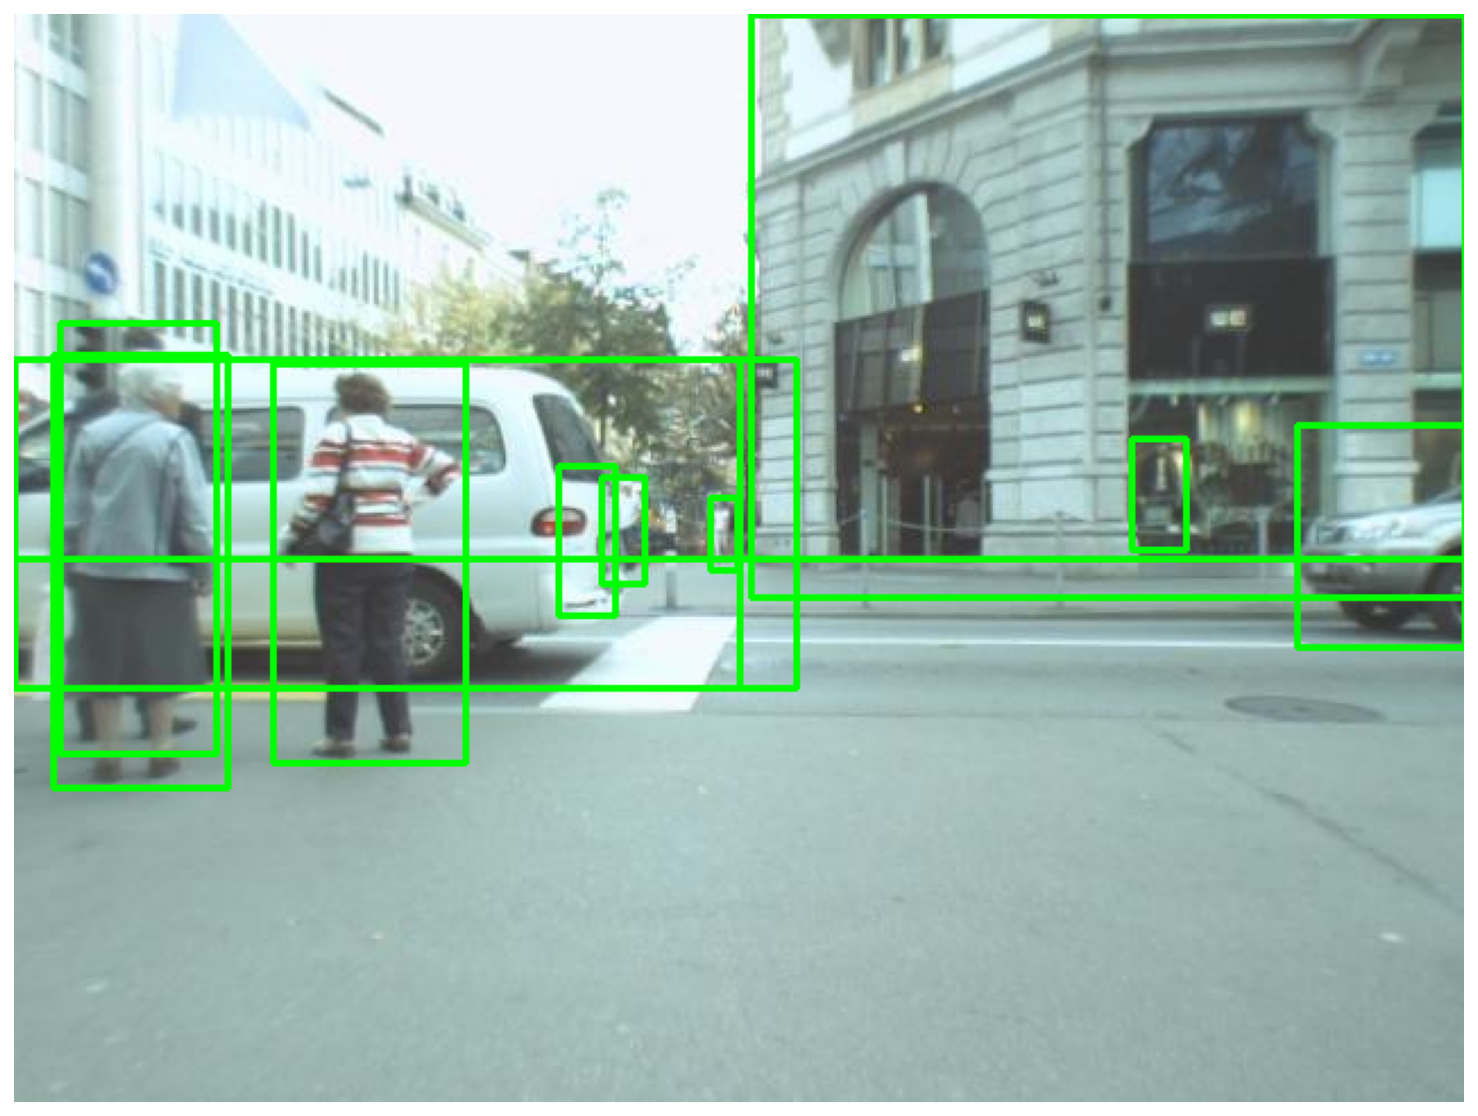

In [94]:
train_parent_dir = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/'
train_filename = "MOT17-05/images/000001.jpg"
gt_bbs = gt_bbs_for_frame[train_filename]

img = cv2.cvtColor(cv2.imread(train_parent_dir+train_filename), cv2.COLOR_BGR2RGB)
segmented_bbs, bb_organized_by_quadrant = segment(img, gt_bbs, (2, 2))

for segmented_bb in segmented_bbs: 
    print(segmented_bb)
    ## draw bounding box
    bb_left, bb_top, bb_width, bb_height = segmented_bb
    bb_tl, bb_br = getTLandBR(int(bb_left), int(bb_top), int(bb_width), int(bb_height))
#     print(bb_tl, bb_br)
    cv2.rectangle(img, bb_tl, bb_br, color=(0, 255, 0), thickness = 2)

#     ## trajectory to person
#     x_midpoint = int(img.shape[1]/2)
#     bb_b_mid = int(bb_br[0] - int(bb_width)/2)
#     img = cv2.line(img,(bb_b_mid, bb_br[1]),(x_midpoint,img.shape[0]),(255,0,0),5)

plt.imshow(img)
plt.axis('off')

In [95]:
from PIL import Image, ImageDraw
## single image
train_parent_dir = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-05/images/'
train_filename = "000001.jpg"
infile = train_parent_dir+train_filename
output_sample_segment_dir = "/Users/arkwl/Desktop/Workstation/cs230-robot-project/PyTorch-YOLOv3-master/data/segmented/"

img = Image.open(infile)
width, height = img.size

x_size = int(width/2)
y_size = int(height/2)

iter_count = 0
# Save Chops of original image
for x0 in range(0, width, x_size):
    for y0 in range(0, height, y_size):
        i = int(x0/x_size)
        j = int(y0/y_size)
        
        bbs_for_frame_for_quadrant = bb_organized_by_quadrant[i][j]
        
        box = (x0, y0,
             x0+x_size if x0+x_size <  width else  width - 1,
             y0+y_size if y0+y_size < height else height - 1)
        print('%s %s' % (infile, box))
        filename = 'test-x%03d-y%03d.jpg' % (x0, y0)
        output_file = output_sample_segment_dir+filename
        print(output_file)
        img.crop(box).save(output_file)
        
        
        name, exstension = filename.split(".")
        f = open(output_sample_segment_dir + name + ".txt", "w")
        
        seg_img = Image.open(output_file)
        img1 = ImageDraw.Draw(img)
        img2 = ImageDraw.Draw(seg_img)
        
        for bbs in bbs_for_frame_for_quadrant:
            bb_left, bb_top, bb_width, bb_height = bbs
            bb_tl, bb_br = getTLandBR(int(bb_left), int(bb_top), int(bb_width), int(bb_height))
            img1.rectangle((bb_tl, bb_br), outline="#ff8888", width = 4)
            
            ## adjust for segmentation
            bb_tl = (bb_tl[0]-x0, bb_tl[1]-y0)
            bb_br = (bb_br[0]-x0, bb_br[1]-y0)
#             print(str(bb_left)+ " " + str(bb_top) + " "+ str(bb_width)+ " " + str(bb_height))
            if (bb_width >= 15 or bb_height >= 15): # we dont want weird thin/long rects
                f.write("0" + " " + str(bb_left)+ " " + str(bb_top) + " "+ str(bb_width)+ " " + str(bb_height) + "\n")
                
                img2.rectangle((bb_tl, bb_br), outline="#ff8888", width = 4)
        f.close()
        
        
#         if (iter_count==1):
#             break
#         iter_count += 1
        seg_img.save(filename)
img.save(train_filename)  
print(seg_img.filename)     



/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-05/images/000001.jpg (0, 0, 320, 240)
/Users/arkwl/Desktop/Workstation/cs230-robot-project/PyTorch-YOLOv3-master/data/segmented/test-x000-y000.jpg
/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-05/images/000001.jpg (0, 240, 320, 479)
/Users/arkwl/Desktop/Workstation/cs230-robot-project/PyTorch-YOLOv3-master/data/segmented/test-x000-y240.jpg
/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-05/images/000001.jpg (320, 0, 639, 240)
/Users/arkwl/Desktop/Workstation/cs230-robot-project/PyTorch-YOLOv3-master/data/segmented/test-x320-y000.jpg
/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/MOT17-05/images/000001.jpg (320, 240, 639, 479)
/Users/arkwl/Desktop/Workstation/cs230-robot-project/PyTorch-YOLOv3-master/data/segmented/test-x320-y240.jpg
/Users/arkwl/Desktop/Workstation/cs230-robot-project/PyTorch-YOLOv3-master/data/segmented/test-x320-y240.jpg


# Full pipeline! Transforms dir into segmented images and bb

In [92]:
from PIL import Image
train_parent_dir = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/train/'
output_sample_segment_dir = '/Users/arkwl/Desktop/Workstation/cs230-robot-project/export/'

f_train = open(output_sample_segment_dir + "train.txt", "w")
f_val = open(output_sample_segment_dir + "val.txt", "w")
f_test = open(output_sample_segment_dir + "test.txt", "w")
idx_for_image = 0

segmented_filenames = []

l = list(gt_bbs_for_frame.items())
random.shuffle(l)
gt_bbs_for_frame = dict(l)

for (filename, gt_bbs) in gt_bbs_for_frame.items():
    infile = train_parent_dir + filename
    img = Image.open(infile)
    img_full = cv2.cvtColor(cv2.imread(infile), cv2.COLOR_BGR2RGB)
    _, bb_organized_by_quadrant = segment(img_full, gt_bbs, (2, 2))
    
    width, height = img.size

    x_size = int(width/2)
    y_size = int(height/2)

    # Save Chops of original image
    bb_text = ""
    for x0 in range(0, width, x_size):
        for y0 in range(0, height, y_size):
            i = int(x0/x_size)
            j = int(y0/y_size)

            bbs_for_frame_for_quadrant = bb_organized_by_quadrant[i][j]

            box = (x0, y0, x0+x_size if x0+x_size <  width else  width - 1, y0+y_size if y0+y_size < height else height - 1)
            input_name, input_exstension = filename.split(".")
            input_name = input_name.replace("/", "-")
            segmented_filename = 'test-%s-x%03d-y%03d.jpg' % (input_name, x0, y0)
            segmented_filenames.append(segmented_filename)
            
            output_file = output_sample_segment_dir+"images/"+segmented_filename
            img.crop(box).save(output_file)
            
            for bbs in bbs_for_frame_for_quadrant:
                bb_left, bb_top, bb_width, bb_height = bbs
                bb_tl, bb_br = getTLandBR(int(bb_left), int(bb_top), int(bb_width), int(bb_height))

                ## adjust for segmentation
                bb_tl = (bb_tl[0]-x0, bb_tl[1]-y0)
                bb_br = (bb_br[0]-x0, bb_br[1]-y0)
                
                if (bb_width >= 15 or bb_height >= 15): # we dont want weird thin/long rects
                    bb_text += (str(bb_tl[0])+","+str(bb_tl[1])+","+str(bb_br[0])+","+str(bb_br[1])+",0 ")
            
    ##
        if (idx_for_image > len(gt_bbs_for_frame)-100):
            f_test.write("/content/drive/MyDrive/ColabNotebooks/cs230robot-tensorflow-REALONE/segmented_images/"+segmented_filename+ " " + bb_text + "\n")
        elif (idx_for_image > len(gt_bbs_for_frame)-200):
            f_val.write("/content/drive/MyDrive/ColabNotebooks/cs230robot-tensorflow-REALONE/segmented_images/"+segmented_filename+ " " + bb_text + "\n")
        else:
            f_train.write("/content/drive/MyDrive/ColabNotebooks/cs230robot-tensorflow-REALONE/segmented_images/"+segmented_filename+ " " + bb_text + "\n")

    idx_for_image = idx_for_image + 1 
            
f_test.close()
f_val.close()
f_train.close()   

In [ ]:
files = segmented_filenames
random.shuffle(files)

train_data = files[:677]
test_data = files[677:]
print("TRAINING FILES")
for train_file in train_data: 
    train_filename, extension = train_file.split(".")
    print("data/custom/segmented/"+train_filename+".jpg")

In [ ]:
print("TEST FILES")
for test_file in test_data: 
    test_filename, extension = test_file.split(".")
    print("data/custom/segmented/"+test_filename+".jpg")